# Project: Analyzing NYC High School Data

## Goal

We want to explore relationships between SAT scores and demographic factors in New York City public schools. 

## Introduction

For a brief bit of background, the [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. We will combine the following data sets into a single, clean pandas dataframe:

* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

## Data information

We'll work with files placed in school folder:

* ap_2010.csv - Data on AP test results
* class_size.csv - Data on class size
* demographics.csv - Data on demographics
* graduation.csv - Data on graduation outcomes
* hs_directory.csv - A directory of high schools
* sat_results.csv - Data on SAT scores
* survey_all.txt - Data on surveys from all schools
* survey_d75.txt - Data on surveys from New York City district 75

survey_all.txt and survey_d75.txt are in a text format. They are tab delimited and encoded with Windows-1252 encoding

Some observations are given on these files:

* Each data set appears to either have a DBN column, or the information we need to create one. That means we can use a DBN column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical DBNs, then group all of their columns together in a single data set.
* Some fields look interesting for mapping -- particularly Location 1, which contains coordinates inside a larger string.
* Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each data set. If we don't do this, we'll run into problems when we combine the data sets, because we might be merging two rows in one data set with one row in another data set.

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys
Some information is given about the data:

* There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.
* The survey data has a dbn column that we'll want to convert to uppercase (DBN). The conversion will make the column name consistent with the other data sets.

First, we'll need to filter the columns to remove the ones we don't need. Luckily, there's a data dictionary at [the original data download location](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8). The dictionary tells us what each column represents. Based on our knowledge of the problem and the analysis we're trying to do, we can use the data dictionary to determine which columns to use.

In [2]:
# survey_all.txt and survey_d75.txt are in txt format

#  Data on surveys from all schools
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')

#Data on surveys from New York City district 75
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

# Here the relevant columns based on the dictionary
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

When we explored all of the data sets, we noticed that some of them, like class_size and hs_directory, don't have a DBN column. hs_directory does have a dbn column, though, so we can just rename it.

However, class_size doesn't appear to have the column at all. After a short analysis with the DBN column from SAT data, we can tell that the DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric
We'll define a new column that totals up the SAT scores for the different sections of the exam. This will make it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

Before we can generate this column, we'll need to convert the SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score columns in the sat_results data set from the object (string) data type to a numeric data type. Whith the argument errors="coerce" when we call pandas.to_numeric() pandas treats any invalid strings it can't convert to numbers as missing values instead.

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

Next, we'll want to parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hs_directory data set.

In [5]:
data["hs_directory"]["Location 1"].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

As you can see, this field contains a lot of information we don't need. We want to extract the coordinates, which are in parentheses at the end of the field. Here's an example:

    1110 Boston Road\nBronx, NY 10456\n(40.8276026690005, -73.90447525699966)
    
We want to extract the latitude, 40.8276026690005, and the longitude, -73.90447525699966. Taken together, latitude and longitude make up a pair of coordinates that allows us to pinpoint any location on Earth.

In [6]:
# We extract our information with a regular expression
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets
The DBN column were unique in the sat_results data set. Other data sets like class_size had duplicate DBN values, however.

We'll need to condense these data sets so that each value in the DBN column is unique. If not, we'll run into issues when it comes time to combine the data sets. To resolve this issue, we'll condense the class_size, graduation, and demographics data sets so that each DBN is unique.

Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.

Each school can have multiple program types. Because GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.

But despite these tranformations, DBN still isn't completely unique. This is due to the CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns. By displaying  the unique values in these columns, we noticed that they only seems to include certain subjects. We want our class size data to include every single class a school offers. 

What we can do is take the average across all of the classes a school offers. This will give us unique DBN values, while also incorporating as much data as possible into the average.

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size


Let's now condense demographics:

the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.

In [8]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

Finally, we'll need to condense the graduation data set.

The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [9]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric
High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are much more rare in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.

There are three columns we'll need to convert:

* AP Test Takers (note that there's a trailing space in the column name)
* Total Exams Taken
* Number of Exams with scores 3 4 or 5

In [10]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets
Both the ap_2010 and the graduation data sets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them. Because we're using a left join, our final dataframe will have all of the same DBN values as the original sat_results dataframe.

For class_size, demographics, survey, and hs_directory we'll use the inner join type because these files contain information that's more valuable to our analysis and also have fewer missing DBN values

### Filling in missing value
There are several ways to handle missing data. Here, we'll just fill in the missing values with the overall mean for the column.

Note that if a column consists entirely of null or NaN values, pandas won't be able to fill in the missing values when we use the df.fillna() method along with the df.mean() method, because there won't be a mean.

We should fill any NaN or null values that remain after the initial replacement with the value 0. We can do this by passing 0 into the df.fillna() method.

In [11]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping
We've finished cleaning and combining our data! We now have a clean data set on which we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

The school district is just the first two characters of the DBN. We can apply a function over the DBN column of combined that pulls out the first two letters.

In [12]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations
Correlations tell us how closely related two columns are. We'll be using the r value, also called [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient), which measures how closely two sequences of numbers are correlated.

Because we're interested in exploring the fairness of the SAT, a strong positive or negative correlation between a demographic factor like race or gender and SAT score would be an interesting result meriting investigation. If men tended to score higher on the SAT, for example, that would indicate that the SAT is potentially unfair to women, and vice-versa.

We can use the pandas pandas.DataFrame.corr() method to find correlations between columns in a dataframe. The method returns a new dataframe where the index for each column and row is the name of a column in the original data set.

In [13]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations
There are several fields in combined that originally came from a survey of **parents, teachers, and students**. Make a bar plot of the correlations between these fields and sat_score.

To find cooreclations, consult the data dictionary that's part of the zip file you can download [from the City of New York's website](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8).

In [14]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


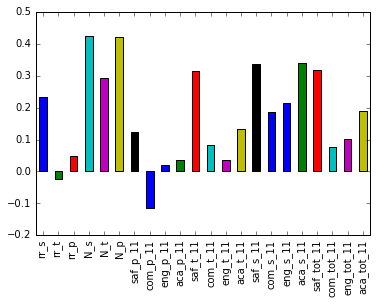

In [16]:
# Set up matplotlib to work in Jupyter notebook.
%matplotlib inline

combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between N_s (Number of student respondents), N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

## Exploring Safety and SAT Scores
We have noticed that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score. Here, we'll dig into this relationship a bit more, and try to figure out which schools have low safety scores.

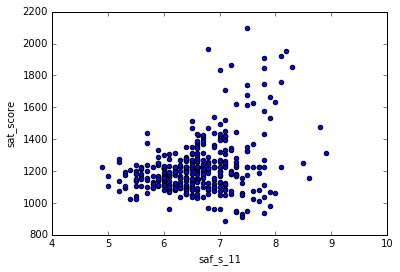

In [19]:
combined.plot.scatter("saf_s_11", "sat_score")

There appears to be a correlation between SAT scores and safety, although **it isn't that strong**. It looks like :

* there are a few schools with extremely high SAT scores and high safety scores. 
* there are a few schools with low safety scores and low SAT scores. 
* no school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so

In [27]:
boros=combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

## Exploring Race and SAT Scores
There are a few columns that indicate the percentage of each race at a given school:

* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

In [28]:
race_fields=["white_per","asian_per","black_per","hispanic_per"]

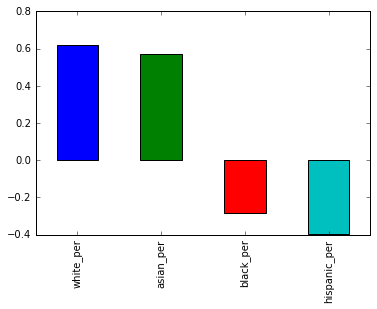

In [30]:
correlations[race_fields].plot.bar()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

We'll explore schools with low SAT scores and high values for hispanic_per

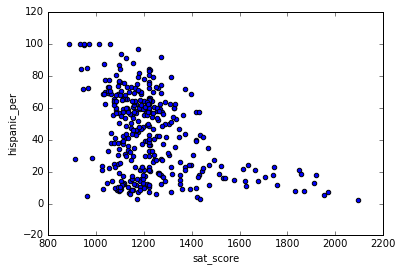

In [31]:
combined.plot.scatter("sat_score",'hispanic_per')

In [32]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [35]:
print(combined[combined["hispanic_per"]<10]["SCHOOL NAME"][:5])

37                              STUYVESANT HIGH SCHOOL
46     HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                       BRONX HIGH SCHOOL OF SCIENCE
187                     BROOKLYN TECHNICAL HIGH SCHOOL
192                        BEDFORD ACADEMY HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Exploring Gender and SAT Scores
There are two columns that indicate the percentage of each gender at a school:

* male_per
* female_per

We can plot out the correlations between each percentage and sat_score to investigate gender differences in SAT score & schools with high score and a high female_per

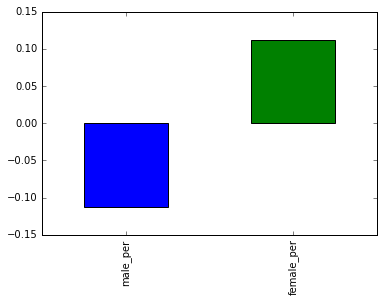

In [38]:
correlations[["male_per","female_per"]].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

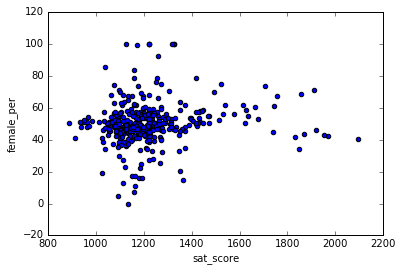

In [40]:
combined.plot.scatter("sat_score","female_per")

In [46]:
print(combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores. 

These schools appears to be very selective liberal arts schools that have high academic standards.

## Exploring AP Scores vs. SAT Scores
In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [47]:
# Calculate the percentage of students in each school that took an AP exam
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]

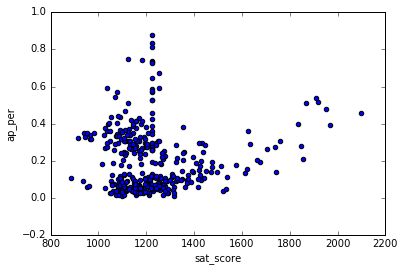

In [53]:
combined.plot.scatter("sat_score","ap_per")

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

## Next steps
We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:

* Determing wheter there's a correlation between class size and SAT scores
* Figuring out which neighborhoods have the best schools
    * If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on sat_score and other attributes.